# Multiclass Logistic Regression Classifier

### Joseph Melby, 2023

In this notebook, we will build a logistic classifier that can handle more than two classes (mostly)
from scratch. (My goal is to use as few built-in functions from scikit-learn, etc. as possible). 

### Setup

Suppose we have $N$ observations, each one with $M$ features, and each belonging to one of $K$ classes. ($\#K
\geq 2$). With a normal logistic regression binary classifier, we have $\#K=2$, and all the following
still holds. 

We may represent this model in the following way:

$$ X^{N \times M} W^{M \times K} \Rightarrow Y^{N \times 1}$$

where 
- the matrix $X$ with entry $X_{i,j}$ representing observation $i$ with feature $j$
- the matrix $W$ with entry $W_{j,k}$ representing the weights for feature $j$ and class $k$
- the vector $Y$ with entry $Y_i$ representing person $i$ belonging to class $k$

Our goal is to find $W$ and use it to predict the class membership of any observation (row) of $X$.

#### Workflow

- If $X$ and $W$ are known, such as when we initialize $W$ to be the zero matrix, we begin by
calculating their product. In particular, let

$$ Z := - X W$$

- Next, we take the softmax function of each row of $Z$:

$$ P_i = softmax(Z_i) = \frac{exp(Z_i)}{\sum_{k=0}^{K} exp(Z_{i,k})}$$

Note that since each row $Z_i$ is the product of each row $X_i$ of $X$ with the entire matrix $W$,
each row $P_i$ of $P$ sums to 1. This is also called the row-wise Softmax.

- Finally, we take the argmax of each row in order to identify the class with the highest
  probability for each observation. This is called the row-wise argmax.

#### Likehood Function

Since we are given $Y$, we know the class $Y_i$ of each observation $X_i$. In particular, the
likelihood function of $Y_i$ given $X_i$ and $W$ is the probability that class $k = Y_i$, which is
given by the softmax of $Z_i$ as discussed above.

$$ p(Y_i | X_i, W) = \frac{exp(-X_i W_{k = Y_i})}{\sum_{k=0}^K exp(-X_i W_k)}.$$

The likelihood of $Y$ given $X$ and $W$ is then just given by the product 

$$ p(Y | X, W) = \prod_{i=1}^N \frac{exp(-X_i W_{k = Y_i})}{\sum_{k=0}^K exp(-X_i W_k)}.$$

#### Loss Function

We will use the negative log-likelihood function (normalized by sample size). First, we note that
$W_{k= Y_i}$ represents a one-hot encoded $Y_i$ and can be written

$$W_{k = Y_i} = W Y_{i (one-hot-encoded)}^T$$

so we have 

$$\sum_{i=1}^N X_i W_{k = Y_i} = Tr(XWY^T_{one-hot-encoded})$$

Now we can write down our loss function:

$$L(W) = \frac{-1}{N} \log p(Y | X, W)$$
$$ = \frac{1}{N} \left(\sum_{i=1}^N \left(X_i W_{k=y_i} + \sum_{i=1}^N \log \sum_{k=0}^K
exp(-X_i W_k) \right)\right)$$

In matrix form:

$$ L(W) = \frac{1}{N} \left(\sum_{i=1}^N \left(X_i WY^T_{i (one-hot-encoded)} + \sum_{i=1}^N \log \sum_{k=0}^K
exp(-X_i W_k) \right)\right)$$
$$ = \frac{1}{N} \left(Tr(XWY^T_{one-hot-encoded}) + \sum_{i=1}^N \log \sum_{k=0}^K
exp(-X_i W_k) \right)$$

#### Regularization Term

We will often want to add either an $l_2$ or $l_1$ regularization term to this loss function, giving
us 

$$f(W) = L(W) + \mu ||W||$$
$$ = \frac{1}{N} \left(\sum_{i=1}^N \left(X_i W_{k=y_i} + \sum_{i=1}^N \log \sum_{k=0}^K
exp(-X_i W_k) \right)\right) + \mu ||W||$$

#### Gradient Calculation

Now we can calculate the gradient of our regularized loss function $f$. Note that the gradient of
$W_{k = Y_i}$ with respect to $W_k$ is the identity matrix $I_{k=Y_i}$.

$$\nabla_{W_k} f(W) = \frac{1}{N} \sum_{i=1}^N \left(X_i^T I_{k=Y_i} - X_i^T \frac{exp(-X_i
W_k)}{\sum_{k=0}^K exp(-X_i W_k)} \right) + 2 \mu W$$
$$ = \frac{1}{N} \sum_{i=1}^N \left(X_i^T I_{k=Y_i} - X_i^T P_i \right) + 2 \mu W$$
$$ = \frac{1}{N} \left(\sum_{i=1}^N X_i^T I_{k=Y_i} - \sum_{i=1}^N X_i^T P_i \right) + 2 \mu W$$
$$ = \frac{1}{N} \left(X^T \left(Y_{ohe} - P \right)\right) + 2 \mu W$$

### Multiclass Model Implementation

We are now ready to give a basic implementation of this gradient descent algorithm and the loss
function. Then we will build a custom class for the multiclass logistic regression model.

It is worth noting that we will just use a couple built-in functionality from the libraries,
particularly the softmax function and one-hot-encoder, though these can be written from scratch too. 

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax
from sklearn.model_selection import train_test_split

ONE = OneHotEncoder(sparse_output=False)

# Simple accuracy function to use for our classifier
def accuracy(true, predicted):
    return np.sum(true==predicted)/len(predicted)

In [34]:
def loss(X, Y, W):
    ## Assuming here that Y is one-hot-encoded

    # Define Z
    Z = -X @ W

    N = X.shape[0]

    # define loss
    loss = 1/N * (np.trace(X @ W @ Y.T) + np.sum(np.log(np.sum(np.exp(Z), axis=1))))

    return loss

def gradient(X, Y, W, mu):
    ## Assuming here that Y is one-ho-encoded

    Z = -X @ W
    P = softmax(Z, axis=1)
    N = X.shape[0]
    grad = 1/N * (X.T @ (Y - P)) + 2* mu * W

    return grad

def gradient_descent(X, Y, max_iter = 1000, eta = 0.1, mu = 0.01):

    # OHE Y and reshape
    Y_ohe = ONE.fit_transform(Y.reshape(-1, 1))
    # Initialize W to be the zero matrix
    W = np.zeros((X.shape[1], Y_ohe.shape[1]))

    step = 0
    step_list = []
    loss_list = []
    W_list = []

    while step < max_iter:
        step += 1
        W -= eta* gradient(X, Y_ohe, W, mu)
        step_list.append(step)
        W_list.append(W)
        loss_list.append(loss(X, Y_ohe, W))

    df = pd.DataFrame({'step': step_list,
                       'loss': loss_list})
    return df, W

In [35]:
class MulticlassLR:
    def fit(self, X, Y):
        self.loss_steps, self.W = gradient_descent(X, Y)

    def loss_plot(self):
        return self.loss_steps.plot(x = 'step',
                                    y = 'loss',
                                    xlabel = 'step',
                                    ylabel = 'loss')
    
    def predict(self, H):
        Z = - H @ self.W
        P = softmax(Z, axis=1)
        return np.argmax(P, axis=1)

### Iris Data Set

In [36]:
## to get the iris data
from sklearn.datasets import load_iris

0.9733333333333334

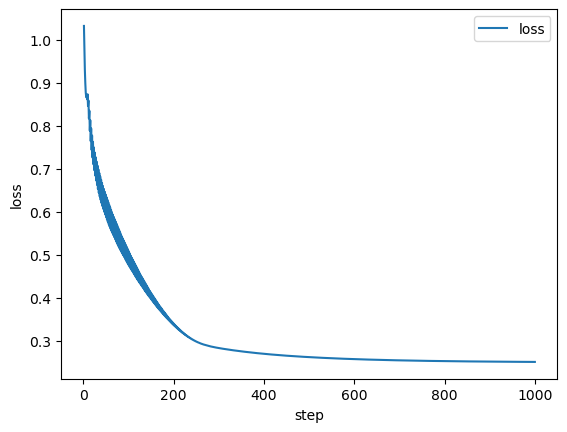

In [37]:
X = load_iris().data
Y = load_iris().target

model = MulticlassLR()
model.fit(X, Y)

model.loss_plot()

accuracy(Y, model.predict(X))

Now let's explore a bit with a train-test split

In [38]:

## Load the data
iris = load_iris()
iris_df = pd.DataFrame(iris['data'], columns = ['sepal_length','sepal_width','petal_length','petal_width'])
iris_df['iris_class'] = iris['target']

In [39]:
## Making a statified train test split
iris_train, iris_test = train_test_split(iris_df, 
                                            random_state=431,
                                            shuffle=True,
                                            test_size=.25,
                                            stratify=iris_df['iris_class'])

In [40]:
# Define our input and output for the training data
X_train = iris_train[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].to_numpy()
X_test = iris_test[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].to_numpy()

y_train = iris_train.iris_class.to_numpy()
y_test = iris_test.iris_class.to_numpy()

##### Fit Model 

0.9910714285714286

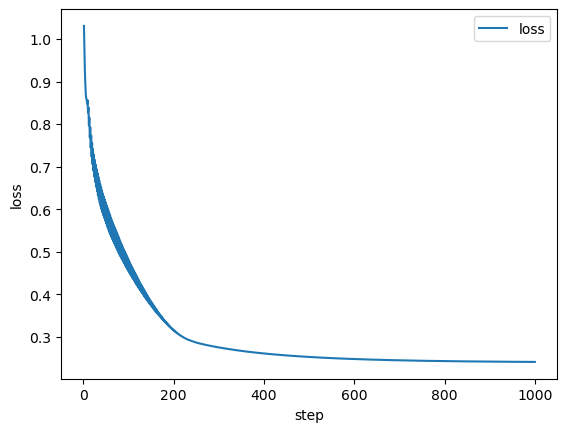

In [42]:
mlr = MulticlassLR()
mlr.fit(X_train, y_train)

mlr.loss_plot()

accuracy(y_train, mlr.predict(X_train))

In [43]:
mlr.predict(X_test)

array([2, 0, 2, 2, 0, 2, 2, 1, 2, 0, 2, 1, 0, 0, 0, 1, 0, 2, 1, 0, 2, 2,
       2, 2, 1, 1, 1, 0, 1, 0, 2, 1, 2, 2, 0, 0, 1, 2], dtype=int64)

In [44]:
accuracy(y_test, mlr.predict(X_test))

0.9210526315789473